# ALF Tutorial 2.0 
## Introductory examples and exercises

This notebook is part of the [Tutorial 2.0](https://git.physik.uni-wuerzburg.de/ALF/ALF_Tutorial) for the quantum Monte Carlo simulation package [*Algorithms for Lattice Fermions* - ALF](https://git.physik.uni-wuerzburg.de/ALF/ALF_code), and can be found, together with its required files, in the [pyALF repository](https://git.physik.uni-wuerzburg.de/ALF/pyALF). [**WE SHOULD MAKE IT PUBLIC.**]

ALF is compiled from source, which is downloaded from the [ALF repository](https://git.physik.uni-wuerzburg.de:ALF) when not found locally.

[**REMEMBER TO UPDATE GIT ADDRESSES**]

## Example 1 - Testing against ED

In this first example we run the code with the Mz choice of Hubbard Stratonovitch  transformation on a four site ring, at $U/t=4$  and inverse temperature $ \beta t = 2 $.  For this set of parameters, the exact  internal energy reads:   
$$
 \left\langle -t \sum_{\langle i,j\rangle, \sigma} c_{i,\sigma}^{\dagger} c_{j,\sigma}^{\phantom\dagger}   +  U  \sum_{i=1}^{N} n_{i,\uparrow}n_{j,\downarrow}  \right\rangle  =   -1.47261997 t 
$$
 
To reproduce this result we will have to carry out a systematic $\Delta \tau  t $ extrapolation keeping    $\Delta \tau t  L_\text{Trotter} = 2$  constant.   
 Recall that  the formulation of the auxiliary field QMC approach is based on the Trotter  decomposition 
$$
e^{-\Delta \tau \left( A + B \right ) }   = e^{-\Delta \tau  A } e^{-\Delta \tau  B  }   + {\cal O}  \left( \Delta \tau^2 \right)
$$
The overall error produced by this  approximation is of the order $\Delta \tau^2  $.  

Bellow we go through the steps for performing this extrapolation: setting the simulation parameters, running it and analysing the data.

---

1. Import `Simulation` class from the `py_alf` python module, which provides the interface with ALF, as well as mathematics and plotting packages:

In [1]:
from py_alf import Simulation            # Interface with ALF
# 
import numpy as np                       # Numerical library
from scipy.optimize import curve_fit     # Numerical library
import matplotlib.pyplot as plt          # Plotting library

2. Create instances of `Simulation`, specifying the necessary parameters, in particular the different $\Delta \tau$ values:

In [100]:
sims = []                                # Vector of Simulation instances
print('dtau values used:')
for dtau in [0.05, 0.1, 0.15]:           # Values of dtau
    print(dtau)
    sim = Simulation({                   # Model and simulation parameters for each Simulation instance
        'Model': 'Hubbard',              #    Base model
        'Lattice_type': 'Square',        #    Lattice type
        'L1': 4,                         #    Lattice length in the first unit vector direction
        'L2': 1,                         #    Lattice length in the second unit vector direction
        'Checkerboard': False,           #    Whether checkerboard decomposition is used or not
        'Symm': True,                    #    Whether symmetrization takes place
        'ham_T': 1.0,                    #    Hopping parameter
        'ham_U': 4.0,                    #    Hubbard interaction
        'ham_Tperp': 0.0,                #    For bilayer systems
        'beta': 2.0,                     #    Inverse temperature
        'Ltau': 0,                       #    '1' for time-displaced Green functions; '0' otherwise 
        'NSweep': 200,                  #    Number of sweeps
        'NBin': 2000,                      #    Number of bins
        'Dtau': dtau,                    #    Only dtau varies between simulations, Ltrot=beta/Dtau
        'HS': '0',
        },
        sim_dir='dt_{}'.format(dtau),    # Separate directories for different simulations
        executable='Examples',           # Appropriate ALF executable
        alf_dir='~/Programs/ALF',        # Local ALF copy, if present
    )
    sims.append(sim)

dtau values used:
0.05
0.1
0.15


3. Compile ALF, downloading it first if not found locally. This may take a few minutes:

In [3]:
sims[0].compile()                        # Compilation needs to be performed only once

4. Perform the simulations, as specified in each element of `sim`:

In [101]:
for i, sim in enumerate(sims):
    sim.run()                            # Perform the actual simulation in ALF

Prepare directory "/home/stafusa/ALF/pyALF/dt_0.05" for Monte Carlo run.
Run /home/stafusa/Programs/ALF/Prog/Examples.out
Prepare directory "/home/stafusa/ALF/pyALF/dt_0.1" for Monte Carlo run.
Run /home/stafusa/Programs/ALF/Prog/Examples.out
Prepare directory "/home/stafusa/ALF/pyALF/dt_0.15" for Monte Carlo run.
Run /home/stafusa/Programs/ALF/Prog/Examples.out


5. Calculate the internal energies:

In [102]:
ener = np.empty((3, 2))                  # Matrix for storing energy values
dtaus = np.empty((3,))                   # Matrix for Dtau values, for plotting
for i, sim in enumerate(sims):
    print(sim.sim_dir)                   # Directory containing the simulation output
    sim.analysis()                       # Perform default analysis
    dtaus[i] = sim.sim_dict['Dtau']                             # Store Dtau value
    ener[i] = sim.get_obs(['Ener_scalJ'])['Ener_scalJ']['obs']  # Store internal energy

/home/stafusa/ALF/pyALF/dt_0.05
Analysing Ener_scal
Analysing Part_scal
Analysing Pot_scal
Analysing Kin_scal
Analysing Den_eq
Analysing SpinZ_eq
Analysing Green_eq
/home/stafusa/ALF/pyALF/dt_0.1
Analysing Ener_scal
Analysing Part_scal
Analysing Pot_scal
Analysing Kin_scal
Analysing Den_eq
Analysing SpinZ_eq
Analysing Green_eq
/home/stafusa/ALF/pyALF/dt_0.15
Analysing Ener_scal
Analysing Part_scal
Analysing Pot_scal
Analysing Kin_scal
Analysing Den_eq
Analysing SpinZ_eq
Analysing Green_eq


In [6]:
dtaus

array([0.05, 0.1 , 0.15])

In [103]:
ener

array([[-1.474289,  0.00689 ],
       [-1.461203,  0.00667 ],
       [-1.447513,  0.007173]])

[-1.47629407  1.31631917] [0.00687304 0.49343698]


<ErrorbarContainer object of 3 artists>

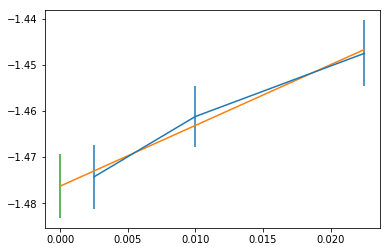

In [104]:
plt.errorbar(dtaus**2, ener[:, 0], ener[:, 1])

def func(x, y0, a):
    return y0 + a*x**2
popt1, pcov = curve_fit(func, dtaus, ener[:, 0], sigma=ener[:, 1], absolute_sigma=True)
perr1 = np.sqrt(np.diag(pcov))
print(popt1, perr1)
xs = np.linspace(0., dtaus.max())
plt.plot(xs**2, func(xs, *popt1))

plt.errorbar(0, popt1[0], perr1[0])